In [1]:
# For Matrix Operations
import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

# For Plotting
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go

# For TDA
import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot

In [2]:
def persistence(array, dimension=None):
  height, width = array.shape
  cubeComplex = gudhi.CubicalComplex(
      dimensions = [width,height],
      top_dimensional_cells = 255 - array.flatten()
  )
 
  if dimension == None:
    persistence = cubeComplex.persistence()
  else:
    cubeComplex.compute_persistence()
    persistence = cubeComplex.persistence_intervals_in_dimension(dimension)
    
  return persistence
def Get_Vinyard(f, g, D, t = 101):
##########
    # input:
        # f and g by which you want to interpolate using straight line homotopy
        # the dimension of persistence you want
    # output:
        # series of persistence diagrams: hs
        # persistence vinyard polotted in 3d space: res
        # death value of largest persistence: mx

##########


    # creates equal intervals from 0 to 100
    ts = np.linspace(0,1,t)
    # creates homology from f to g using these intervals
    hs = np.array([(t * f) + (1-t) * g for t in ts])
    
    PDD = [persistence(h,dimension = D) for h in hs]

# tracking each vine. the third entry tracks what vine is matche dup to what wasserstein point
    # vines[0] is birth frame
    # vines[1] is death frame
    # vines[2] keeps track of what point the vine is in the corresponding persistence diagram
    vines = [[0, None, [x,]] for x in range(len(PDD[0]))]
    # each vine is matched to itself in the ends matrix
    ends = {x:x for x in range(len(PDD[0]))}

    for i in range(1, len(ts)):
        dist, match = gudhi.hera.wasserstein_distance(PDD[i-1], PDD[i], matching = True)

        baby = [] 

        new_ends = {k:ends[k] for k in ends}
        for j, (x,y) in enumerate(match):
            if x == -1:
                baby.append(j)
            elif y == -1:
                # ends the vine
                
                # we record death frame
                vines[ends[x]][1] = i
                # -1 tells us the vine is dead in our PD
                vines[ends[x]][2].append(-1)
            else:
                # updating vines. Adding the match to our vines matrix
                vines[ends[x]][2].append(y)
                # setting ends to new_ends for the next iteration
                new_ends[y] = ends[x] 

        for j in baby:
            x, y = match[j]
            new_ends[y] = len(vines)
            vines.append([i, None, [y,]])
            # print(f"new {y} -> *")

        for k in [l for l in ends]: 
            if k >= len(PDD[i]):
                del new_ends[k]

        ends = new_ends


    # this block takes the tracking in vines[i][2] and replaces it with the numpy array of the vines birth and death times.
    # these times are taken at each time step of our vinyard
    # for example: poss[1][2][3] is the birth/death times of vine number 2 at time step 4. Note that indices are 1 less than their frame #
    poss = vines
    for i,_ in enumerate(vines):
        repl = []
        for j,x in enumerate(vines[i][2]):
            # if vine is dead at that frame
            if x == -1:
                repl.append(np.mean(PDD[vines[i][0]+j-1][vines[i][2][j-1]])*np.ones((2,))) # proj prev
            else:
                repl.append(PDD[vines[i][0]+j][x])
        poss[i][2] = np.array(repl)




    # these are the vine values in 3d space

    # we iterate through each vine, to create a res entry (res[0] corresponds to vine zero)
    # res[0][b(t) -> d(t)] is a triple list consisting of:
        # [time value, birth time, death time]

    res = [[[ts[p[0]+np.arange(len(p[2]))][i], *x] for i,x in enumerate(p[2])] for p in poss]

    mx = 'hey'
    #mx = np.max([np.max(p[2]) for p in poss if np.inf not in p[2]])
    # getting the max death time of all the vines

    return res, mx, hs
def Plot_Vinyard(res, mx, hs):


    gos = []

    # x axis is time
    # y axis is birth time
    # z axis is death time
    for vine in res:
        vine = np.array(vine)

        gos.append(go.Scatter3d(x=vine[:,0], y=vine[:,1], z=vine[:,2], marker=dict(
            size=2,
        ),
        line=dict(
            width=2
        )))


    xs = np.linspace(0, mx, 10)
    zs = np.linspace(0, 1, 10)
    xss, zss = np.meshgrid(xs, zs)
    gos.append(go.Surface(x=zss, y=xss, z=xss, colorscale=[[0, '#333'], [1, '#333']], opacity=0.1, showscale=False)) # x - y = 0: diag plane
    fig = go.Figure(data=gos)

    fig.update_layout(
        width=800,
        height=700,
        scene=dict(
        xaxis_title='T (homotopy)',
        yaxis_title='Birth',
        zaxis_title='Death'
    )
    )

    fig.show()
def vdist(res, f, g): # diag weight func, length weight func
    V = 0
    for vine in res:
        vine = np.array(vine)
        v, L = 0, 0
        for i in range(1, len(vine)):
            l = np.linalg.norm(vine[i][1:]-vine[i-1][1:])
            dt = vine[i][0] - vine[i-1][0]

            mid = np.mean([vine[i][1:],vine[i-1][1:]], axis=0)
            proj = np.mean(mid)*np.ones(2,)
            # this is the persistence of the mid point distance traveled
            D = np.linalg.norm(proj-mid)
            
            v += f(D)*l*dt
            L += l*dt

        v *= g(L)
        V += v

    return V
def fD(D):
    return D/100
def fL(L):
    return 1


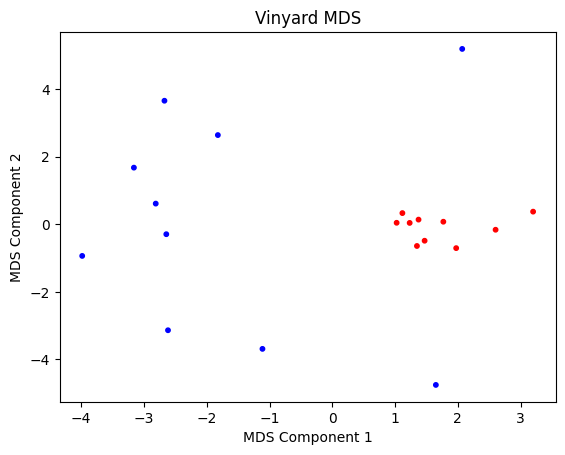

array([[0.00000000e+00, 2.97124401e-01, 8.89721207e-01, 8.82378709e-01,
        9.98921308e-01, 4.62685756e-01, 4.79836345e-01, 1.52674122e+00,
        1.54645458e+00, 3.23269635e-01, 4.40208423e+00, 4.29604243e+00,
        4.54731977e+00, 5.77232580e+00, 4.04020898e+00, 4.38198174e+00,
        4.73585310e+00, 4.29361679e+00, 5.59523241e+00, 4.82867178e+00],
       [2.97124401e-01, 0.00000000e+00, 2.91356208e-01, 1.09474612e+00,
        1.13397540e+00, 7.08747677e-02, 9.90951053e-01, 3.46019591e-01,
        1.29390225e+00, 3.89957061e-02, 4.93188853e+00, 4.41577882e+00,
        4.66278376e+00, 6.65824032e+00, 4.36159308e+00, 5.42602372e+00,
        4.05698138e+00, 3.86410334e+00, 6.19313456e+00, 3.26517098e+00],
       [8.89721207e-01, 2.91356208e-01, 0.00000000e+00, 3.47319509e-02,
        6.03362357e-01, 0.00000000e+00, 1.60343480e-01, 4.09230088e-01,
        4.71322769e-02, 3.52694052e-01, 4.42881050e+00, 4.09337801e+00,
        4.25433414e+00, 4.38043935e+00, 4.13654620e+00, 3.3537

In [4]:
def Test_Mnist(N1, N2, dimension = 1, no_samples = 100):

    # fetching Mnist, finding a three and a eight. Creating an f and g for our test:

    X, y = fetch_openml('Mnist_784', version = 1, return_X_y = True, as_frame = False)
    # X is 70000 images, y is the classifications
    X.shape
    # taking each image and turning it into a 3d array. Each slide is a 28 by 28 grayscale grid

    X = X.reshape(X.shape[0],28,28)

    # finding all the 6's and 9's and filtering them out
    f = X[np.where(y == str(N1))]
    g = X[np.where(y == str(N2))]


    if no_samples > len(f) or no_samples >len(g):
        no_samples = max(len(f), len(g))
    f = f[:no_samples]
    g = g[:no_samples]

    Combined_Array = np.concatenate((f, g), axis = 0)

    # Distances Calculations
    Vinyard_Distances = np.zeros((Combined_Array.shape[0], Combined_Array.shape[0]))

    for i in range(Combined_Array.shape[0]):
        for j in range(i+1,Combined_Array.shape[0]):
            Vinyard_Distances[i,j] = vdist(Get_Vinyard(Combined_Array[i], Combined_Array[j],dimension, t = 100)[0],fD,fL)
    Vinyard_Distances += np.transpose(Vinyard_Distances)

    # MDS Embedding
    Vinyard_MDS_Embedding = MDS(n_components = 2, metric = True, dissimilarity = 'precomputed', random_state = 32).fit_transform(Vinyard_Distances)


    # Plotting
    fig, ax = plt.subplots()

    # Red is N1 and Blue is N2
    scatter = ax.scatter(Vinyard_MDS_Embedding[:, 0], Vinyard_MDS_Embedding[:, 1], c = ['red'] * no_samples + ['blue'] * no_samples, s=10)


    plt.title('Vinyard MDS')
    plt.xlabel('MDS Component 1')
    plt.ylabel('MDS Component 2')
    plt.show()
    return Vinyard_Distances
Test_Mnist(4,9, dimension = 1, no_samples = 50)

## Hypothesis Testing
See [Turner and Robinson Paper](https://arxiv.org/pdf/1310.7467)

In [ ]:
# Hypothesis testing between 6 and 9
N1 = 6
N2 = 9

# 100 samples of 6's and 9's are drawn each
no_samples = 100
# In robinson and turner, they take 10 samples from each group and compute the loss function.

def loss_function(PDS, metric = 'wasserstein'):
    if metric == 'wasserstein':
        n = len(PDS)
        loss = 0
        for i, PD1 in enumerate(PDS): 
            for j, PD2 in enumerate(PDS):
                if i <= j:
                    loss += (gudhi.hera.wasserstein_distance(PD1, PD2))
        
        loss *= (1/(2 * n*(n-1)))
        return loss

    elif metric == 'vinyard':
            pass

    return 'blruh'


# fetching Mnist, finding a three and a eight. Creating an f and g for our test:

X, y = fetch_openml('Mnist_784', version = 1, return_X_y = True, as_frame = False)
# X is 70000 images, y is the classifications
X.shape
# taking each image and turning it into a 3d array. Each slide is a 28 by 28 grayscale grid

X = X.reshape(X.shape[0],28,28)

# finding all the 6's and 9's and filtering them out
f = X[np.where(y == str(N1))]
g = X[np.where(y == str(N2))]

In [31]:
def loss_matrix(PDS):
    lm = np.zeros((len(PDS), len(PDS)))
    for i in range(len(PDS)):
        for j in range(len(PDS)):
            if i < j:
                lm[i][j] = gudhi.hera.wasserstein_distance(PDS[i], PDS[j])
    lm += np.transpose(lm)

    return lm
np.random.seed(123456789)
# sourcing images
f = X[np.where(y == str(N1))]
g = X[np.where(y == str(N2))]
# setting persistence dimension and length of our straight line homotopy
D = 1
t = 10

# at each time step k, this is the amount of images we pull out of f or g
p = 10
# for each set of 10 images, this is the number of permutations we go through
N = 10000
# list that will store all of our Z values
ZsW = []

for i in range(100):
    f_test = f[i* 10 :10*(i+1)]
    g_test = g[i * 10:10*(i+1)]

    # Generating PDS
    PDS1 = [persistence(six,1) for six in f_test]
    PDS2 = [persistence(nine,1) for nine in g_test]
    PDS_Combined = PDS1 + PDS2


    # getting observed loss and loss matrix
    loss_observed = 0
    lm = loss_matrix(PDS_Combined)
    label1 = [x for x in range(10)]
    label2 = [10 + x for x in range(10)]

    for i, _ in enumerate(label1):
        for j, _ in enumerate(label1):
            if i<= j:
                loss_observed += lm[label1[i]][label1[j]]
                loss_observed += lm[label2[i]][label2[j]]
    #loss_observed *= (1/(2 * p*(p-1)))

    #calculating observed loss and initializing Z
    
    Z = 0

    for i in range(N):

        # Shuffling the labels
        rand_perm = np.random.permutation(len(PDS_Combined))
        label1 = rand_perm[:10]
        label2 = rand_perm[10:]

        loss = 0

        # computing the loss functions again
        for i, _ in enumerate(label1):
            for j, _ in enumerate(label1):
                if i<= j:
                    loss += lm[label1[i]][label1[j]]
                    loss += lm[label2[i]][label2[j]]
        #loss *= (1/(2 * p*(p-1)))
        # if loss <= observed loss: Z += 1
        if loss <= loss_observed:
            Z += 1
    Z /= (N+1)
    ZsW.append(Z)
ZsW = np.array(ZsW)

In [32]:
def loss_matrix(PDS):
    lm = np.zeros((len(PDS), len(PDS)))
    for i in range(len(PDS)):
        for j in range(len(PDS)):
            if i < j:
                lm[i][j] = gudhi.hera.wasserstein_distance(PDS[i], PDS[j])
    lm += np.transpose(lm)

    return lm
np.random.seed(123456789)
# sourcing images
f = X[np.where(y == str(N1))]
g = X[np.where(y == str(N2))]
# setting persistence dimension and length of our straight line homotopy
D = 1
t = 10

# at each time step k, this is the amount of images we pull out of f or g
p = 10
# for each set of 10 images, this is the number of permutations we go through
N = 10000
# list that will store all of our Z values
ZsW2 = []

for i in range(100):
    f_test = f[i* 10 :10*(i+1)]
    g_test = g[i * 10:10*(i+1)]

    # Generating PDS
    PDS1 = [persistence(six,1) for six in f_test]
    PDS2 = [persistence(nine,1) for nine in g_test]
    PDS_Combined = PDS1 + PDS2


    # getting observed loss and loss matrix
    loss_observed = 0
    lm = loss_matrix(PDS_Combined)
    label1 = [x for x in range(10)]
    label2 = [10 + x for x in range(10)]

    for i, _ in enumerate(label1):
        for j, _ in enumerate(label1):
            #if i<= j:
            loss_observed += lm[label1[i]][label1[j]]
            loss_observed += lm[label2[i]][label2[j]]
    loss_observed *= (1/(2 * p*(p-1)))

    #calculating observed loss and initializing Z
    
    Z = 0

    for i in range(N):

        # Shuffling the labels
        rand_perm = np.random.permutation(len(PDS_Combined))
        label1 = rand_perm[:10]
        label2 = rand_perm[10:]

        loss = 0

        # computing the loss functions again
        for i, _ in enumerate(label1):
            for j, _ in enumerate(label1):
                #if i<= j:
                loss += lm[label1[i]][label1[j]]
                loss += lm[label2[i]][label2[j]]
        loss *= (1/(2 * p*(p-1)))
        # if loss <= observed loss: Z += 1
        if loss <= loss_observed:
            Z += 1
    Z /= (N+1)
    ZsW.append(Z)
ZsW2 = np.array(ZsW)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
print(ZsW)
print(ZsW2)

In [ ]:
# setting random seed
np.random.seed(123456789)
# sourcing images
f = X[np.where(y == str(N1))]
g = X[np.where(y == str(N2))]
# setting persistence dimension and length of our straight line homotopy
D = 1
t = 10

# at each time step k, this is the amount of images we pull out of f or g
p = 10
# for each set of 10 images, this is the number of permutations we go through
N = 10000
# list that will store all of our Z values
ZsV = []

# initializing loss observed and 
# we are taking 10 6's and 10 9's and repeating the loss function 100 times. This will give us 100 Z's to work with
for k in range(100):

    f_test = f[k * p : p * (k + 1)]
    g_test = g[k * p : p * (k + 1)]

    loss_observed = 0
    Z = 0


    # arrays
    Combined_Array = np.concatenate((f_test, g_test), axis = 0)

    Vin_Cost_Array = np.zeros((len(Combined_Array), len(Combined_Array)))

    # computing cost array
    for i in range(Vin_Cost_Array.shape[0]):
        for j in range(Vin_Cost_Array.shape[0]):
            if i < j:
                Vin_Cost_Array[i][j] = vdist(Get_Vinyard(Combined_Array[i], Combined_Array[j], D = 1 ,t= 11)[0], fD, fL)
    Vin_Cost_Array += np.transpose(Vin_Cost_Array)

    # getting the observed loss functions

    # standard labels [1, 2, ..., 10] and [11, 12, ..., 19]

    label1 = [x for x in range(10)]
    label2 = [10 + x for x in range(10)]


    for i, _ in enumerate(label1):
        for j, _ in enumerate(label1):
            if i<= j:
                loss_observed += Vin_Cost_Array[label1[i]][label1[j]]
                loss_observed += Vin_Cost_Array[label2[i]][label2[j]]
    loss_observed *= (1/(2 * p*(p-1)))


    for n in range(N):

        rand_perm = np.random.permutation(len(Combined_Array))
        label1 = rand_perm[:10]
        label2 = rand_perm[10:]
        loss = 0
        for i, _ in enumerate(label1):
            for j, _ in enumerate(label1):
                if i<= j:
                    loss += Vin_Cost_Array[label1[i]][label1[j]]
                    loss += Vin_Cost_Array[label2[i]][label2[j]]
        loss *= (1/(2 * p*(p-1)))
    
        if loss <= loss_observed:
            Z += 1

    Z /= (N+1)
    ZsV.append(Z)
ZsV = np.array(ZsV)

In [ ]:
print(f'wasserstein: {ZsW}')
print(f'vineyard: {ZsV}')
ZsW = np.array(ZsW)
ZsV = np.array(ZsV)

In [ ]:
alpha = [0.005, 0.01, 0.015, 0.02, 0.025]
yvals = [np.sum(ZsW <=a) for a in alpha]
plt.plot(alpha,yvals)